In [1]:
import random
import collections
import seaborn as sns
import os
import glob
import numpy as np
import re
import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, confusion_matrix, multilabel_confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.linear_model import SGDClassifier
plt.style.use('ggplot')

random.seed(42)
np.random.seed(42)

Создание датафреймов с сырыми данными (столбцы: автор *(по названию папки)*, фамилия автора на русском *(из файла AUTHOR.txt в каждой папке)*, название произведения, текст произведения) и сохранение в csv. Выполняется поиск произведений в папках texts/{ds}_txt/\*\* (вместо {ds} — TRAIN или TEST).

In [2]:
for ds in ['train', 'test']:
    # Находим все текстовые файлы
    FILE_PATHS = glob.glob(f'texts/{ds.upper()}_txt/**/*.txt', recursive=True)
    # Находим файлы с информацией о каждом авторе (AUTHOR.txt, сейчас там только фамилия на русском)
    AUTHOR_INFO_PATHS = glob.glob(f'texts/{ds.upper()}_txt/**/AUTHOR.txt', recursive=True)
    
    # Создаем словарь "автор" (название папки) - "фамилия" (из файла AUTHOR.txt в этой папке) 
    AUTHOR__RUS_SURNAME__DICT = dict()
    for path in AUTHOR_INFO_PATHS:
        with open(path, 'r', encoding='utf-8') as f:
            AUTHOR__RUS_SURNAME__DICT[path.split("\\")[-2]] = f.readline().split(':')[-1]
    
    # Создаем словарь "название произведения" (по названию файла) - "путь к файлу"
    TITLE_PATH_DICT = {path.split("\\")[-1].split(".")[0] : path for path in FILE_PATHS}
    del TITLE_PATH_DICT['AUTHOR']
    # Создаем словарь "название произведения" - "автор" 
    TITLE_AUTHOR_DICT = {path.split("\\")[-1].split(".")[0] : path.split("\\")[-2] for path in FILE_PATHS}
    del TITLE_AUTHOR_DICT['AUTHOR']
    
    # Создаем датафрейм и сохраняем
    dataset_list = []
    for title, path in TITLE_PATH_DICT.items():
        with open(path, 'r', encoding='utf-8') as f:
            text = f.read()[:-2000]
        author = TITLE_AUTHOR_DICT[title]
        dataset_list.append({
            'author': author,
            'author_surname': AUTHOR__RUS_SURNAME__DICT[author],
            'work_title': title,
            'text': text
        })
    df_raw = pd.DataFrame(dataset_list)
    df_raw.to_csv(f'datasets/raw_{ds}.csv', index=False)

In [3]:
df_train_raw = pd.read_csv('datasets/raw_TRAIN.csv')
df_test_raw = pd.read_csv('datasets/raw_TEST.csv')

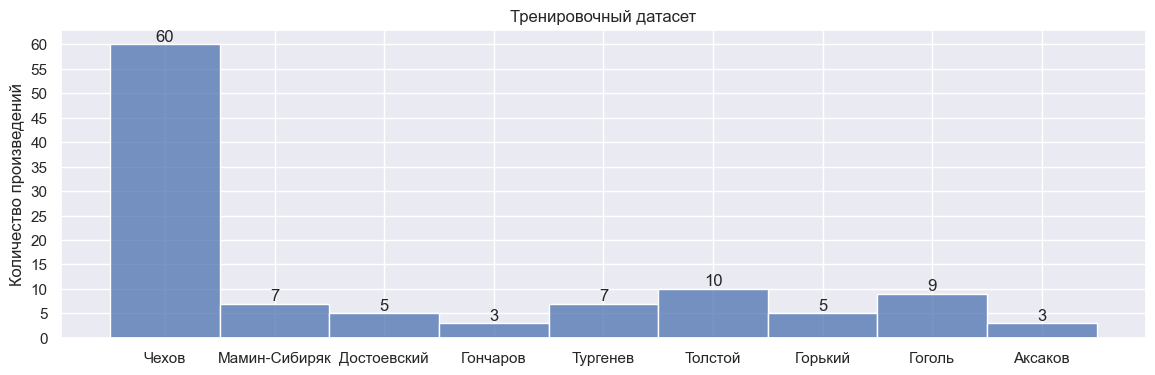

In [4]:
sns.set(rc={'figure.figsize':(14,4)})
y = sns.histplot(data=df_train_raw, x='author_surname')
y.set(xlabel='', ylabel='Количество произведений')
y.bar_label(y.containers[0])
plt.title('Тренировочный датасет')
plt.yticks(np.arange(0, 61, 5))
plt.show();

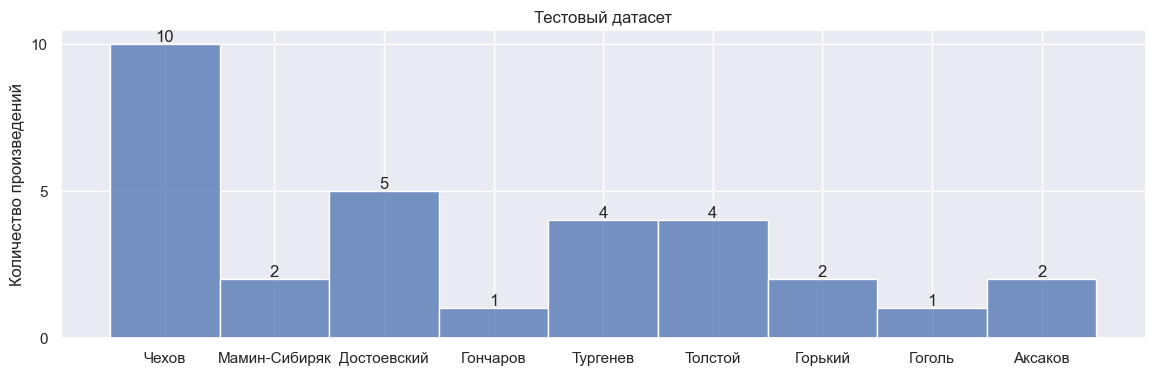

In [5]:
sns.set(rc={'figure.figsize':(14,4)})
y = sns.histplot(data=df_test_raw, x='author_surname')
y.set(xlabel='', ylabel='Количество произведений')
y.bar_label(y.containers[0])
plt.title('Тестовый датасет')
plt.yticks(np.arange(0, 12, 5))
plt.show();

In [6]:
df_train_raw.sample()

,author,author_surname,work_title,text
78,ivan-turgenev,Тургенев,rudin,I \n Было тихое летнее утро. Солнце уже доволь...


### Разбиение произведений на отрывки по $\approx500$ слов

In [7]:
# Вспомогательная функция для получения в списке words (полученного из строки методом split)
# индекса последнего слова в предложении после слова с индексом start.
def get_idx_of_last_word_in_sentence(words, start=0):
    idx = start
    for word in words[start:]:
        for char in word:
            if char in ".?!…":
                return idx
        idx += 1
    return idx

# Разбивает текст на отрывки по excerpt_num_of_words слов (+ слова до конца последнего предложения).
# Последний отрывок не включается, если он имеет длину меньше excerpt_num_of_words слов.
def text_to_excerpts(text, excerpt_num_of_words) -> list:
    if excerpt_num_of_words < 1:
        raise ValueError("excerpt_num_of_words must be >0")
    words = text.replace('\n', '|n|').split()
    excerpts = []
    idx = 0
    while idx < len(words):
        last_word_idx = get_idx_of_last_word_in_sentence(
            words, 
            start=min(len(words)-1, idx+excerpt_num_of_words-1)
        )
        
        excerpt_list = words[idx:last_word_idx+1]
        if len(excerpt_list) >= excerpt_num_of_words:
            excerpts.append(' '.join(excerpt_list).replace('|n|', '\n'))
        idx = last_word_idx + 1
    return excerpts

In [8]:
example = "Раз. Два! Три? Четыре… Пять?! Шесть, семь, восемь, девять. Десять!!!"
text_to_excerpts(example, 2)

['Раз. Два!', 'Три? Четыре…', 'Пять?! Шесть, семь, восемь, девять.']

In [9]:
# Из датафрейма с текстами создает датафрейм с отрывками 
# по excerpt_num_of_words слов (+ слова до конца последнего в отрывке предложения).
def df_with_texts_to_df_with_excerpts(df, excerpt_num_of_words=500):
    dataset_list = []
    with tqdm(total=df.shape[0]) as pbar:
        for index, row in df.iterrows():
            excerpts = text_to_excerpts(row['text'], excerpt_num_of_words)
            for i in range(len(excerpts)):
                excerpt = excerpts[i]
                dataset_list.append({
                    'author': row['author'],
                    'author_surname': row['author_surname'],
                    'work_title': row['work_title'],
                    'excerpt_num': i,
                    'text': excerpt
                })
            pbar.update(1)
    return pd.DataFrame(dataset_list)

In [10]:
df_train = df_with_texts_to_df_with_excerpts(df_train_raw)
df_test = df_with_texts_to_df_with_excerpts(df_test_raw)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 56.06it/s]


In [11]:
df_train.to_csv('datasets/TRAIN_500words.csv', index=False)
df_test.to_csv('datasets/TEST_500words.csv', index=False)

In [12]:
df_train = pd.read_csv('datasets/TRAIN_500words.csv')
df_test = pd.read_csv('datasets/TEST_500words.csv')

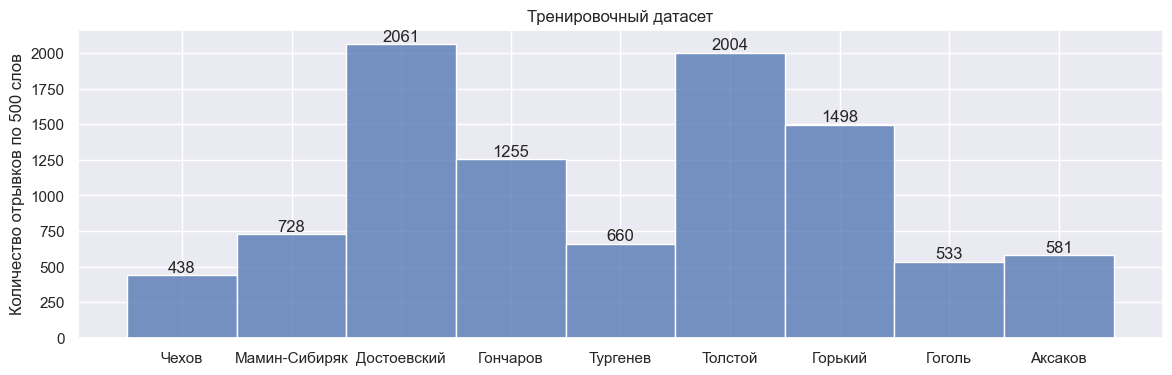

In [13]:
sns.set(rc={'figure.figsize':(14,4)})
y = sns.histplot(data=df_train, x='author_surname')
y.set(xlabel='', ylabel='Количество отрывков по 500 слов')
y.bar_label(y.containers[0])
plt.title('Тренировочный датасет')
plt.show();

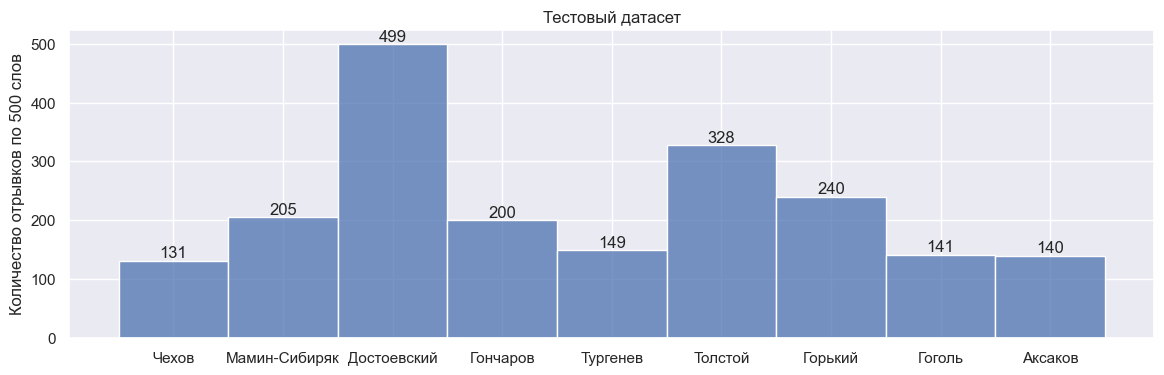

In [14]:
sns.set(rc={'figure.figsize':(14,4)})
y = sns.histplot(data=df_test, x='author_surname')
y.set(xlabel='', ylabel='Количество отрывков по 500 слов')
y.bar_label(y.containers[0])
plt.title('Тестовый датасет')
plt.show();

In [15]:
df_test.shape

(2033, 5)

In [16]:
df_test

,author,author_surname,work_title,excerpt_num,text
0,anton-chekhov,Чехов,aktyorskaya-gibel,0,Актёрская гибель \n Благородный отец и простак...
1,anton-chekhov,Чехов,aktyorskaya-gibel,1,"\n — Ты, я слышал, заболел? — обратился он к Щ..."
2,anton-chekhov,Чехов,aktyorskaya-gibel,2,"Ну, и касторки, конечно. Постой, где бы коньяк..."
3,anton-chekhov,Чехов,beglec,0,Беглец \n Это была длинная процедура. Сначала ...
4,anton-chekhov,Чехов,beglec,1,Доктор лениво поглядел на него и похлопал его ...
...,...,...,...,...,...
2028,sergey-aksakov,Аксаков,semeinaya-khronika,122,"Будучи еще не старым человеком, он носил совер..."
2029,sergey-aksakov,Аксаков,semeinaya-khronika,123,"Читал всегда Алексей Степаныч, получивший в эт..."
2030,sergey-aksakov,Аксаков,semeinaya-khronika,124,Так прошло и девятнадцатое сентября. Двадцатог...
2031,sergey-aksakov,Аксаков,semeinaya-khronika,125,"Наконец, прибежал не помнивший себя от восхище..."


### Добавление столбца с леммами 

In [17]:
# patterns = "[A-Za-z0-9!#$%&'()*+,.…«»/:;<=>?@[\]^_`{|}~—\"\-]+"
patterns = r'[^а-яё ]+'
morph = MorphAnalyzer()

def lemmatize(doc, remove_stop_words=True):
    doc = re.sub(patterns, ' ', doc.lower()).strip()
    tokens = []
    stopwords_ru = stopwords.words("russian") if remove_stop_words else ''
    for token in doc.split():
        if token and token.strip() not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    return tokens

In [18]:
for df in [df_train, df_test]:
    with tqdm(total=df.shape[0]) as pbar:
        df['lemmas'] = df['text'].apply(
            lambda x: (' '.join(lemmatize(x)), pbar.update(1))[0]
        )

100%|██████████████████████████████████████████████████████████████████████████████| 2033/2033 [01:09<00:00, 29.08it/s]


In [19]:
df_train.to_csv('datasets/TRAIN_500words_lemmatized.csv', index=False)
df_test.to_csv('datasets/TEST_500words_lemmatized.csv', index=False)

In [20]:
df_train = pd.read_csv('datasets/TRAIN_500words_lemmatized.csv')
df_test = pd.read_csv('datasets/TEST_500words_lemmatized.csv')

In [21]:
df_train.sample(3)

,author,author_surname,work_title,excerpt_num,text,lemmas
8353,maksim-gorkii,Горький,zhizn-klima-samgina,919,\n — Это — Захар Бердников. \n В ее сочном гол...,это захар бердников сочный голос время звучать...
1685,fedor-dostoevskii,Достоевский,bratya-karamazovy,88,"Что в том, что человек капельку декламирует? Р...",человек капельку декламировать декламировать и...
1851,fedor-dostoevskii,Достоевский,bratya-karamazovy,254,"К утру чуть не весь город говорил о событии, и...",утро весь город говорить событие множество гра...


In [22]:
df_test.sample(3)

,author,author_surname,work_title,excerpt_num,text,lemmas
1617,maksim-gorkii,Горький,foma-gordeev,105,"Что-то горячее лилось в грудь ему, заступая ме...",горячий литься грудь заступать место тот усили...
564,fedor-dostoevskii,Достоевский,prestuplenie-i-nakazanie,82,"Чего еще-то взять? Они думают, что я болен! Он...",взять думать больной знать ходить мочь хе хе х...
770,fedor-dostoevskii,Достоевский,prestuplenie-i-nakazanie,288,"Я тогда поглумился, а теперь вам скажу, что уж...",поглумиться сказать ужасно любить вообще любит...


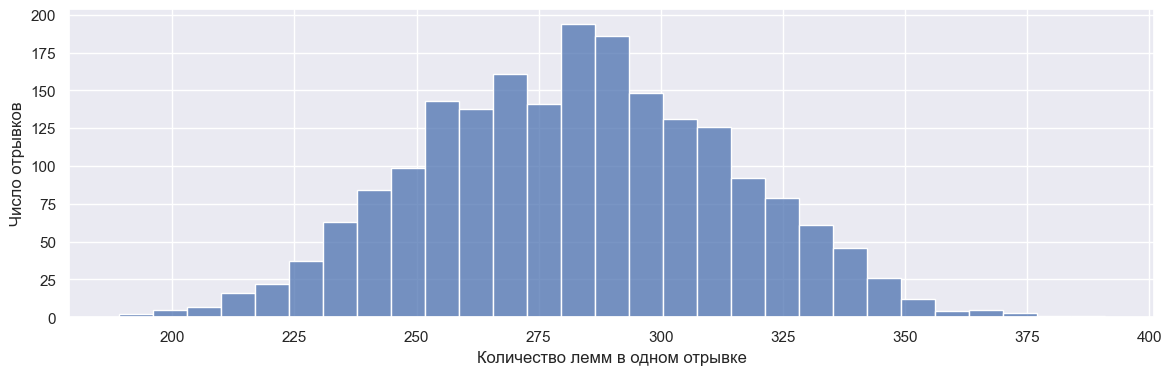

In [23]:
hst = sns.histplot(
    data=df_test['lemmas'].apply(lambda x: len(x.split())),
)
hst.set(xlabel='Количество лемм в одном отрывке')
hst.set(ylabel='Число отрывков')
plt.show();

## Признаки

In [24]:
%%time
patterns = r'[^а-яё.?!…,:;—()\"\'\- ]+'
char_vec_ct = TfidfVectorizer(analyzer='char', ngram_range=(1, 4), sublinear_tf=True) 
ctX_train = char_vec_ct.fit_transform(
    df_train['text'].apply(lambda x: re.sub(patterns, '', x.lower()))
)

CPU times: total: 44.6 s
Wall time: 44.6 s


In [25]:
%%time
char_vec_wl = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), sublinear_tf=True) 
wlX_train = char_vec_wl.fit_transform(df_train['lemmas'])

CPU times: total: 2.02 s
Wall time: 2.01 s


In [26]:
y_train = df_train['author']
X_train = hstack([ctX_train, wlX_train])

## Обучение

In [27]:
clf = SGDClassifier(random_state=42, max_iter=50000, verbose=0, alpha=0.0001,
                    n_jobs=10, loss='modified_huber')
clf.fit(X_train, y_train)

SGDClassifier(loss='modified_huber', max_iter=50000, n_jobs=10, random_state=42)

#### Получение матрицы признаков для тестового датасета 

In [28]:
def get_features(df_test):
    if 'author' in df_test.columns:
        y_test = df_test.author
    else:
        y_test = None
    
    wlX_test = char_vec_wl.transform(df_test['lemmas'])
    ctX_test = char_vec_ct.transform(df_test['text'].apply(lambda x: re.sub(patterns, '', x.lower())))
    
    cX_test =  hstack([ctX_test, wlX_test])
    return cX_test, y_test

#### Предсказываем на тестовом датасете

In [29]:
%%time
X_test, y_test = get_features(df_test)

CPU times: total: 11.4 s
Wall time: 9.85 s


#### F1-score

In [43]:
pred_test = clf.predict(X_test)
f1_score(y_test, pred_test, average='macro')

0.9558134771989111

In [31]:
roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')

0.9982831349589283

#### Для сравнения, простейший бейзлайн (мажоритарный класс)

In [32]:
def baseline(df_train, df_test):
    pred = df_train.groupby(by='author').count()['text'].idxmax()
    return [pred for i in range(df_test.shape[0])]

In [33]:
pred_test_baseline = baseline(df_train, df_test)
f1_score(y_test, pred_test_baseline, average='weighted')

0.09674532923974019

#### Confusion matrix

In [34]:
AUTHOR__RUS_SURNAME__DICT = dict()
for author in y_test.unique():
    AUTHOR__RUS_SURNAME__DICT[author] =\
        df_train[df_train['author'] == author]['author_surname'].iloc[0]

In [35]:
labels = y_test.unique()
labels_r = np.array(list(map(lambda x: AUTHOR__RUS_SURNAME__DICT[x], labels)))
labels_r

array(['Чехов', 'Мамин-Сибиряк', 'Достоевский', 'Гончаров', 'Тургенев',
       'Толстой', 'Горький', 'Гоголь', 'Аксаков'], dtype='<U13')

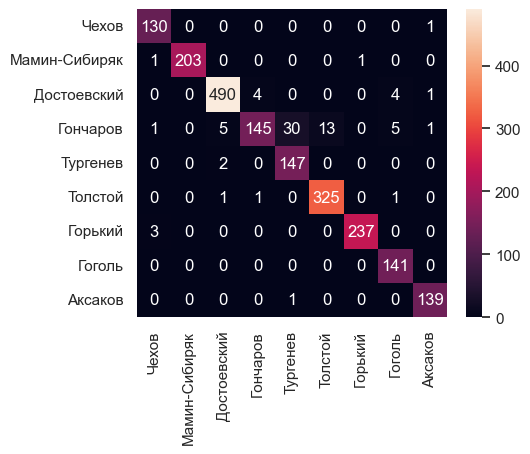

In [36]:
sns.set(rc={'figure.figsize':(5,4)})
sns.heatmap(
    confusion_matrix(y_test, pred_test, labels=labels),
    xticklabels=labels_r,
    yticklabels=labels_r,
    annot=True,
    fmt="d"
)
plt.show();

In [37]:
# def lists_of_works(df):
#     res_list = []
#     for author in df.author_surname.unique():
#         res_list.append({
#             'author': author,
#             'work_list': tuple(df[df.author_surname == author].work_title.unique())
#         })
#     return res_list

# lists_of_works(df_train)

#### Список ошибочно классифицированных объектов

In [38]:
def false_predictions(df, y_true, y_pred):
    res = pd.DataFrame(np.vstack([y_true, y_pred]).T, columns=['y_true', 'y_pred'])
    res = pd.concat([res, df], axis=1)
    res = res.drop('author', axis=1)
    res['lemmas_num'] = res['lemmas'].apply(lambda x: len(x.split()))
    return res[res.y_true != res.y_pred]

false_predictions(df_test, y_test, pred_test)

,y_true,y_pred,author_surname,work_title,excerpt_num,text,lemmas,lemmas_num
7,anton-chekhov,sergey-aksakov,Чехов,belolobyi,1,"\n Она бежала, напрягая силы, а в это время Ар...",бежать напрягать сила это время арапка почуять...,291
247,dmitriy-mamin-sibiryak,maksim-gorkii,Мамин-Сибиряк,cherty-iz-zhizni-pepko,116,"Да... Мне просто опротивело жить, есть, дышать...",просто опротиветь жить дышать смотреть понимат...,310
273,dmitriy-mamin-sibiryak,anton-chekhov,Мамин-Сибиряк,ohoniny-brovi,3,"Такие брови росли, по народному поверью, тольк...",такой бровь расти народный поверье счастливый ...,289
379,fedor-dostoevskii,nikolai-gogol,Достоевский,bednye-lyudi,43,"Правда, что он еще молодой сановник и любит по...",правда молодой сановник любить подчас покричат...,246
397,fedor-dostoevskii,sergey-aksakov,Достоевский,bednye-lyudi,61,В воспоминаниях моих есть что-то такое необъяс...,воспоминание мой такой необъяснимый увлекать б...,307
...,...,...,...,...,...,...,...,...
1478,lev-tolstoi,ivan-goncharov,Толстой,yunost,65,"\n Иногда, и довольно часто, я вставал рано. (...",довольно часто вставать рано спасть открытый в...,372
1586,maksim-gorkii,anton-chekhov,Горький,foma-gordeev,74,"Они ничего не выясняли ему, а лишь увеличивали...",выяснять лишь увеличивать недоумение порождать...,316
1597,maksim-gorkii,anton-chekhov,Горький,foma-gordeev,85,У меня дети... меня все знают! Мер-рзавец... Д...,ребёнок знать мера рзавец дикарь дуэль ухтищев...,238
1632,maksim-gorkii,anton-chekhov,Горький,foma-gordeev,120,"Всё хорошо, всё приятно, — только вы, наследни...",всё всё приятно наследник наш всякий живой чув...,290


#### Важность признаков (топ-15)

In [39]:
def print_top_N_ngrams_by_weight(first_column=0, topN=100, ncolumns=1):
    top_words = []
    for i in range(9):
        top_words_of_author = np.concatenate(
            [char_vec_ct.get_feature_names_out(), char_vec_wl.get_feature_names_out()]
        )[clf.coef_[i].argsort()[-topN:][::-1]]
        coefs = np.sort(clf.coef_[i])[-topN:][::-1]

        tmp = np.empty(topN, dtype=object)
        tmp[:] = list((map(tuple, np.vstack([top_words_of_author, coefs]).T)))
        top_words.append(tmp)

    for author in y_train.unique()[first_column:first_column+ncolumns]:
        print(''.ljust(5) + AUTHOR__RUS_SURNAME__DICT[author].ljust(35), end='')
    print()
    i = 1
    for row in np.array(top_words)[first_column:first_column+ncolumns].T:
        for word, coef in row:
            print(f'{i}.'.ljust(5) + f'<{word}>'.ljust(25, '·') + f'{"%.2f" % coef}'.ljust(10), end='')
        i+= 1
        print('')

In [40]:
print_top_N_ngrams_by_weight(first_column=0, topN=15, ncolumns=3)

     Чехов                                   Мамин-Сибиряк                           Достоевский                        
1.   <акимович>···············1.36      1.   <привал>·················1.38      1.   <лишь>···················1.50      
2.   <урбенин>················1.21      2.   <привалов>···············1.20      2.   <алеш>···················1.46      
3.   <ариадна>················1.05      3.   <катя>···················0.81      3.   <митя>···················1.14      
4.   <оленька>················0.96      4.   <её>·····················0.80      4.   <пред>···················1.12      
5.   <гуров>··················0.92      5.   <галактион>··············0.79      5.   <князь>··················1.06      
6.   <чёрт>···················0.84      6.   <половодовый>············0.75      6.   <нелли>··················1.04      
7.   <граф>···················0.82      7.   <ляховский>··············0.68      7.   <вскричать>··············1.03      
8.   <ольга>··················0.

In [41]:
print_top_N_ngrams_by_weight(first_column=3, topN=15, ncolumns=3)

     Гончаров                                Тургенев                                Толстой                            
1.   <обломов>················2.28      1.   <промолвить>·············1.78      1.   <левин>··················1.75      
2.   <райский>················1.57      2.   <словно>·················1.75      2.   <нехлюдов>···············1.44      
3.   <захар>··················1.14      3.   <санин>··················1.56      3.   <пьер>···················1.28      
4.   <илья>···················1.00      4.   <рудин>··················1.48      4.   <ростов>·················1.09      
5.   <всё>····················0.95      5.   <лаврецкий>··············1.18      5.   <вронский>···············1.05      
6.   <блом>···················0.87      6.   <базар>··················1.15      6.   <сказать>················1.03      
7.   <бабушка>················0.84      7.   <зинаида>················1.10      7.   <жилин>··················1.00      
8.   <ольга>··················0.

In [42]:
print_top_N_ngrams_by_weight(first_column=6, topN=15, ncolumns=3)

     Горький                                 Гоголь                                  Аксаков                            
1.   <самгин>·················2.21      1.   <чичиков>················2.42      1.   <охотник>················1.13      
2.   <клим>···················1.76      2.   <вши >···················1.00      2.   <мать>···················1.13      
3.   <самг>···················0.85      3.   <чичи>···················0.86      3.   <сестрица>···············1.10      
4.   <амги>···················0.85      4.   < чич>···················0.85      4.   <мой>····················0.98      
5.   <мгин>···················0.85      5.   <хлестак>················0.85      5.   <рубановский>············0.96      
6.   <амг>····················0.84      6.   <ичик>···················0.83      6.   <надобный>···············0.93      
7.   <мги>····················0.84      7.   <око>····················0.82      7.   <евсеевич>···············0.89      
8.   <снова>··················0.